In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False
# plt.style.use("ggplot")

%matplotlib inline

p = sns.color_palette()
sns.set_style("darkgrid", {"font.sans-serif": ['simhei', 'Arial']})

通过前面的探索性分析，可以发现直接给出的数据基本没办法直接训练  
现在要做的是将6张表整合起来，筛选与抽取有用的信息

文件组成：
1.	用户的基本属性user_info.txt
	> 共6个字段，其中字段性别为1表示性别未知。
	- 字段组成：
        - 用户id
        - 性别
        - 职业
        - 教育程度
        - 婚姻状态
        - 户口类型
2.	银行流水记录bank_detail.txt
	> 共5个字段，其中，第2个字段，时间戳为0表示时间未知；第3个字段，交易类型有两个值，1表示支出、0表示收入；第5个字段，工资收入标记为1时，表示工资收入。
	字段组成：
	- 用户id,
        - 间戳
        - 交易类型
        - 交易金额
        - 工资收入标记
3.	用户浏览行为browse_history.txt
	> 共4个字段。其中，第2个字段，时间戳为0表示时间未知
	- 字段组成：
        - 用户id
        - 时间戳
        - 浏览行为数据
        - 浏览子行为编号
4.	信用卡账单记录bill_detail.txt
	> 共15个字段，其中，第2个字段，时间戳为0表示时间未知
	- 字段组成：
        - 用户id
        - 账单时间戳
        - 银行id
        - 上期账单金额
        - 上期还款金额
        - 信用卡额度
        - 本期账单余额
        - 本期账单最低还款额
        - 消费笔数
        - 本期账单金额
        - 调整金额
        - 循环利息
        - 可用金额
        - 预借现金额度
        - 还款状态
5.	放款时间loan_time.txt
	- 字段组成：
        - 用户id、
        - 放款时间   
6.	顾客是否发生逾期行为的记录overdue.txt。
	> 样本标签为1，表示逾期30天以上；样本标签为0，表示逾期10天以内。注意：逾期10天~30天之内的用户，并不在此问题考虑的范围内
	- 字段组成：
        - 用户id
        - 是否逾期
        
        
注意：并非每一位用户都有非常完整的记录，如有些用户并没有信用卡账单记录，有些用户却没有银行流水记录。
同时进行了脱敏处理：
- (a)	隐藏了用户的id信息；
- (b)	将用户属性信息全部数字化；
- (c)	将时间戳和所有金额的值都做了函数变换。




# 载入数据

In [2]:
train_loan_time = pd.read_csv(
    "./data/train/loan_time_train.txt", header=None, names=["用户id", "放款时间"])
train_user_info = pd.read_csv("./data/train/user_info_train.txt",
                              header=None, names=['用户id', '用户性别', '用户职业', '用户教育程度',
                                                  '用户婚姻状态', '用户户口类型'])
train_bill_detail = pd.read_csv("./data/train/bill_detail_train.txt", header=None,
                                names=['用户id', '时间', '银行标识', '上期账单金额', '上期还款金额', '信用卡额度',
                                       '本期账单余额', '本期账单最低还款额', '消费笔数', '本期账单金额', '调整金额',
                                       '循环利息', '可用余额', '预借现金额度', '还款状态'])
train_browse_history = pd.read_csv("./data/train/browse_history_train.txt", header=None,
                                   names=['用户id', '浏览时间', '浏览行为数据', '浏览子行为编号'])
train_overdue = pd.read_csv("./data/train/overdue_train.txt", header=None,
                            names=['用户id', '是否逾期'])
train_bank_detail = pd.read_csv("./data/train/bank_detail_train.txt").rename(columns={"uid": "用户id", "timespan": "流水时间",
                                                                                      "type": "交易类型", "amount": "交易金额", "markup": "工资收入标记"})

# 获取用来训练的用户

In [3]:
# 用户数量
print(
    len(train_bank_detail.用户id.unique()),
    len(train_bill_detail.用户id.unique()),
    len(train_browse_history.用户id.unique()),
    len(train_loan_time.用户id.unique()),
    len(train_overdue.用户id.unique()),
    len(train_user_info.用户id.unique())
)
# 可以发现所有表的用户数量都不同

9294 53174 47330 55596 55596 55596


各个表格的id数不一样，说明并非每个用户都有银行卡流水，账单等信息；所以下一步就是整合6张表格，然后根据共有用户id匹配完整信息，没有完整信息的id去掉。

另外，我们要预测的测试集是没有放款的客户，因此训练集分析使用客户放款之前的信息，将有时间戳的表与放款表交叉，只筛选放款前的客户id

有时间字段记录的为银行流水记录表、账单记录表、浏览信息表，

In [4]:
# 依照存有信息的表merge
bank_table = pd.merge(left=train_bank_detail,
                      right=train_loan_time, how="left", on="用户id")

In [5]:
bank_table.head()

,用户id,流水时间,交易类型,交易金额,工资收入标记,放款时间
0,6965,5894316387,0,13.756664,0,5923841487
1,6965,5894321388,1,13.756664,0,5923841487
2,6965,5897553564,0,14.449810,0,5923841487
3,6965,5897563463,1,10.527763,0,5923841487
4,6965,5897564598,1,13.651303,0,5923841487


In [6]:
# 要选出流水时间小于放款时间的
table1 = bank_table[bank_table.流水时间 <= bank_table.放款时间]
table1.head()

,用户id,流水时间,交易类型,交易金额,工资收入标记,放款时间
0,6965,5894316387,0,13.756664,0,5923841487
1,6965,5894321388,1,13.756664,0,5923841487
2,6965,5897553564,0,14.449810,0,5923841487
3,6965,5897563463,1,10.527763,0,5923841487
4,6965,5897564598,1,13.651303,0,5923841487


In [7]:
bank_user = table1[["用户id"]]

In [8]:
bank_user = bank_user.drop_duplicates(subset="用户id", keep="first")

In [9]:
bank_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9271 entries, 0 to 6069672
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   用户id    9271 non-null   int64
dtypes: int64(1)
memory usage: 144.9 KB


In [10]:
# 其他几张表进行同样操作

bill_table = pd.merge(left=train_bill_detail,
                      right=train_loan_time, how="left", on="用户id")
bill_user = bill_table[bill_table.时间 <= bill_table.放款时间][["用户id"]]
bill_user = bill_user.drop_duplicates(subset="用户id", keep="first")
bill_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46739 entries, 0 to 2338115
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   用户id    46739 non-null  int64
dtypes: int64(1)
memory usage: 730.3 KB


In [11]:
browse_table = pd.merge(left=train_browse_history,
                        right=train_loan_time, how="left", on="用户id")
browse_user = browse_table[browse_table.浏览时间 <= browse_table.放款时间][["用户id"]]
browse_user = browse_user.drop_duplicates(subset="用户id", keep="first")
browse_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44945 entries, 0 to 22919430
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   用户id    44945 non-null  int64
dtypes: int64(1)
memory usage: 702.3 KB


In [12]:
# 清理内存
import gc
del table1
del bank_table
del bill_table
del browse_table

gc.collect()

44

In [13]:
# 现在获取三个user_id表中的都有的用户id

user1 = pd.merge(left=bank_user, right=bill_user, how="inner", on="用户id")
user2 = pd.merge(left=user1, right=browse_user, how="inner", on="用户id")
user2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5735 entries, 0 to 5734
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   用户id    5735 non-null   int64
dtypes: int64(1)
memory usage: 89.6 KB


In [14]:
%who

autopep8	 bank_user	 bill_user	 browse_user	 gc	 json	 np	 p	 pd	 
plt	 sns	 train_bank_detail	 train_bill_detail	 train_browse_history	 train_loan_time	 train_overdue	 train_user_info	 user1	 
user2	 


# 筛选数据

从指定的用户中筛选出数据  
用于之后进一步的处理

## 银行流水

In [15]:
bank = pd.merge(left=train_bank_detail, right=user2, how="inner", on="用户id")

In [16]:
del train_bank_detail
gc.collect()

80

In [17]:
bank.head()

,用户id,流水时间,交易类型,交易金额,工资收入标记
0,6965,5894316387,0,13.756664,0
1,6965,5894321388,1,13.756664,0
2,6965,5897553564,0,14.449810,0
3,6965,5897563463,1,10.527763,0
4,6965,5897564598,1,13.651303,0


In [18]:
bank_income = bank[bank["交易类型"] == 0].groupby("用户id", as_index=False)  # 收入

In [19]:
bank_income = bank_income["交易金额"].agg(
    {
        "收入次数": "count",
        "总收入": "sum"
    }
)

In [20]:
bank_pay = bank[bank["交易类型"] == 1].groupby("用户id", as_index=False)  # 支出

In [21]:
bank_pay = bank_pay["交易金额"].agg(
    {
        "支出次数": "count",
        "总支出": "sum"
    }
)

In [22]:
bank_salary = bank[bank["工资收入标记"] == 1].groupby("用户id", as_index=False)  # 收入工资

In [23]:
bank_salary = bank_salary["交易金额"].agg(
    {
        "工资收入次数": "count",
        "总工资": "sum"
    }
)

In [24]:
print(
    bank_income[["用户id"]].count(),
    bank_pay[["用户id"]].count(),
    bank_salary[["用户id"]].count()
)

用户id    5734
dtype: int64 用户id    5730
dtype: int64 用户id    1950
dtype: int64


 可以发现很多用户没有工资收入，  
 也有几个用户只有支出，没有收入  
 所以按照前面得到的user2来构建信息表，缺少的填0

In [25]:
t1 = pd.merge(left=user2, right=bank_income, how="left", on="用户id")
t1.fillna(0, inplace=True)

t2 = pd.merge(left=user2, right=bank_pay, how="left", on="用户id")
t2.fillna(0, inplace=True)

t3 = pd.merge(left=user2, right=bank_salary, how="left", on="用户id")
t3.fillna(0, inplace=True)

In [26]:
bank_train = pd.merge(left=t1, right=t2, how="inner", on="用户id")
bank_train = pd.merge(left=bank_train, right=t3, how="inner", on="用户id")

In [27]:
bank_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5735 entries, 0 to 5734
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   用户id    5735 non-null   int64  
 1   收入次数    5735 non-null   float64
 2   总收入     5735 non-null   float64
 3   支出次数    5735 non-null   float64
 4   总支出     5735 non-null   float64
 5   工资收入次数  5735 non-null   float64
 6   总工资     5735 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 358.4 KB


In [28]:
bank_train.head()

,用户id,收入次数,总收入,支出次数,总支出,工资收入次数,总工资
0,6965,75.0,972.850228,289.0,3234.531975,0.0,0.000000
1,1265,125.0,1708.206195,294.0,3662.457063,0.0,0.000000
2,2583,213.0,2736.475318,618.0,7064.310678,0.0,0.000000
3,29165,189.0,2277.607807,473.0,5099.861165,14.0,202.630532
4,2443,252.0,3020.288782,341.0,3762.790364,0.0,0.000000


In [29]:
%who

autopep8	 bank	 bank_income	 bank_pay	 bank_salary	 bank_train	 bank_user	 bill_user	 browse_user	 
gc	 json	 np	 p	 pd	 plt	 sns	 t1	 t2	 
t3	 train_bill_detail	 train_browse_history	 train_loan_time	 train_overdue	 train_user_info	 user1	 user2	 


In [30]:
del t1
del t2
del t3
del bank_income
del bank_pay
del bank_salary
del user1
del bank_user
del browse_user
del bill_user

gc.collect()

80

In [31]:
%who

autopep8	 bank	 bank_train	 gc	 json	 np	 p	 pd	 plt	 
sns	 train_bill_detail	 train_browse_history	 train_loan_time	 train_overdue	 train_user_info	 user2	 


## 浏览记录

In [32]:
browse = pd.merge(left=user2, right=train_browse_history,
                  how="inner", on="用户id")

In [33]:
browse_group = browse.groupby("用户id", as_index=False)
browse_group.head()

,用户id,浏览时间,浏览行为数据,浏览子行为编号
0,6965,5891711961,201,1
1,6965,5891711898,201,1
2,6965,5891711898,50,6
3,6965,5891711898,173,1
4,6965,5891711898,164,4
...,...,...,...,...
3899703,8917,5924543657,110,7
3899704,8917,5924543657,173,1
3899705,8917,5924543657,101,1
3899706,8917,5924543657,118,1


In [34]:
browse_train = browse_group["用户id"].agg({
    "浏览次数": "count"
})

In [35]:
browse_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5735 entries, 0 to 5734
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   用户id    5735 non-null   int64
 1   浏览次数    5735 non-null   int64
dtypes: int64(2)
memory usage: 134.4 KB


In [36]:
del browse_group
del browse
del train_browse_history
gc.collect()

20

## 账单

In [37]:
bill = pd.merge(left=user2, right=train_bill_detail, how="inner", on="用户id")

In [38]:
bill.drop(["时间", "银行标识", "还款状态"], axis=1, inplace=True)
bill.head()

,用户id,上期账单金额,上期还款金额,信用卡额度,本期账单余额,本期账单最低还款额,消费笔数,本期账单金额,调整金额,循环利息,可用余额,预借现金额度
0,6965,20.027371,19.317344,19.971271,19.983264,16.987546,5,19.194742,0.0,15.728101,0.0,19.278123
1,6965,19.983264,17.915546,19.971271,19.889440,16.893721,2,16.166307,0.0,15.778343,0.0,19.278123
2,6965,0.000000,6.849967,19.971271,19.978909,17.499557,18,19.969689,0.0,15.288139,0.0,19.971271
3,6965,0.000000,6.849967,19.971271,19.978909,17.499557,18,19.969689,0.0,15.288139,0.0,19.971271
4,1265,20.170074,21.438223,20.153592,20.050741,17.055015,0,21.406063,0.0,0.000000,0.0,0.000000


In [39]:
bill_train = bill.groupby("用户id", as_index=False).mean().rename(
    columns={
        "上期账单金额":         "平均上期账单金额",
        "上期还款金额":         "平均上期还款金额",
        "用卡额度":         "平均用卡额度",
        "本期账单余额":         "平均本期账单余额",
        "本期账单最低还款额":         "平均本期账单最低还款额",
        "消费笔数":         "平均消费笔数",
        "本期账单金额":         "平均本期账单金额",
        "调整金额":         "平均调整金额",
        "循环利息":         "平均循环利息",
        "可用余额":         "平均可用余额",
        "预借现金额度":         "平均预借现金额度"
    }
)

In [40]:
del bill
gc.collect()

80

## 逾期用户

In [41]:
overdue_train = pd.merge(
    left=user2, right=train_overdue, how="inner", on="用户id")

In [42]:
overdue_train.head()

,用户id,是否逾期
0,6965,0
1,1265,0
2,2583,0
3,29165,0
4,2443,0


## 表的整合

In [43]:
train_table = pd.merge(left=user2, right=train_user_info,
                       how="left", on="用户id")
train_table = train_table.merge(bank_train)
train_table = train_table.merge(browse_train)
train_table = train_table.merge(bill_train)
train_table = train_table.merge(overdue_train)

In [44]:
train_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5735 entries, 0 to 5734
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   用户id         5735 non-null   int64  
 1   用户性别         5735 non-null   int64  
 2   用户职业         5735 non-null   int64  
 3   用户教育程度       5735 non-null   int64  
 4   用户婚姻状态       5735 non-null   int64  
 5   用户户口类型       5735 non-null   int64  
 6   收入次数         5735 non-null   float64
 7   总收入          5735 non-null   float64
 8   支出次数         5735 non-null   float64
 9   总支出          5735 non-null   float64
 10  工资收入次数       5735 non-null   float64
 11  总工资          5735 non-null   float64
 12  浏览次数         5735 non-null   int64  
 13  平均上期账单金额     5735 non-null   float64
 14  平均上期还款金额     5735 non-null   float64
 15  信用卡额度        5735 non-null   float64
 16  平均本期账单余额     5735 non-null   float64
 17  平均本期账单最低还款额  5735 non-null   float64
 18  平均消费笔数       5735 non-null   float64
 19  平均本期账单

In [45]:
train_table.head()

,用户id,用户性别,用户职业,用户教育程度,用户婚姻状态,用户户口类型,收入次数,总收入,支出次数,总支出,...,信用卡额度,平均本期账单余额,平均本期账单最低还款额,平均消费笔数,平均本期账单金额,平均调整金额,平均循环利息,平均可用余额,平均预借现金额度,是否逾期
0,6965,1,2,4,3,2,75.0,972.850228,289.0,3234.531975,...,19.971271,19.957631,17.220095,10.750000,18.825107,0.000000,15.520681,0.0,19.624697,0
1,1265,1,3,4,3,1,125.0,1708.206195,294.0,3662.457063,...,19.973385,19.909123,17.866453,1.444444,19.007284,0.000000,5.175483,0.0,9.702118,0
2,2583,2,2,2,1,1,213.0,2736.475318,618.0,7064.310678,...,18.307126,17.736937,10.292788,1.791667,17.199134,0.000000,6.478271,0.0,11.014650,0
3,29165,1,2,4,1,4,189.0,2277.607807,473.0,5099.861165,...,19.740221,17.921520,15.902257,0.000000,12.969975,0.000000,0.000000,0.0,6.001719,0
4,2443,1,4,4,3,1,252.0,3020.288782,341.0,3762.790364,...,17.309158,19.397134,18.206423,2.251572,15.892834,0.229931,4.082358,0.0,10.873986,0


In [46]:
%who

autopep8	 bank	 bank_train	 bill_train	 browse_train	 gc	 json	 np	 overdue_train	 
p	 pd	 plt	 sns	 train_bill_detail	 train_loan_time	 train_overdue	 train_table	 train_user_info	 
user2	 


In [47]:
del train_bill_detail
del train_loan_time
del train_overdue
del train_user_info
del user2
del browse_train
del overdue_train
gc.collect()

60

In [48]:
%who

autopep8	 bank	 bank_train	 bill_train	 gc	 json	 np	 p	 pd	 
plt	 sns	 train_table	 


将筛选过后的数据保存

In [49]:
train_table.to_csv("./product/filter_data.csv",index=False)

# 特征工程

## 银行流水分析

<AxesSubplot:>

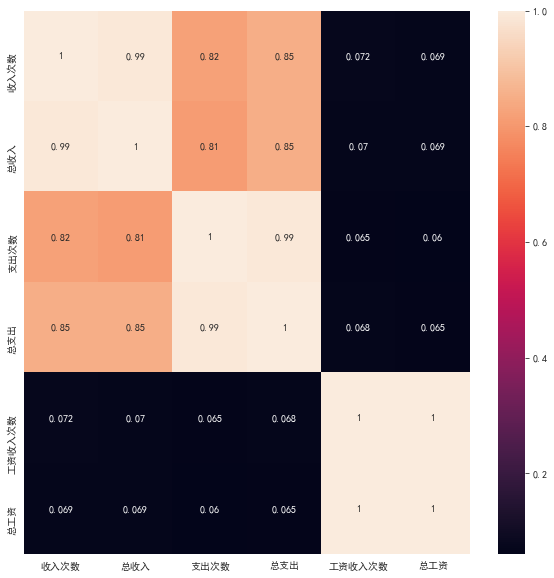

In [50]:
plt.figure(figsize=(10, 10))
sns.heatmap(train_table.iloc[:, 6:12].corr(), annot=True)

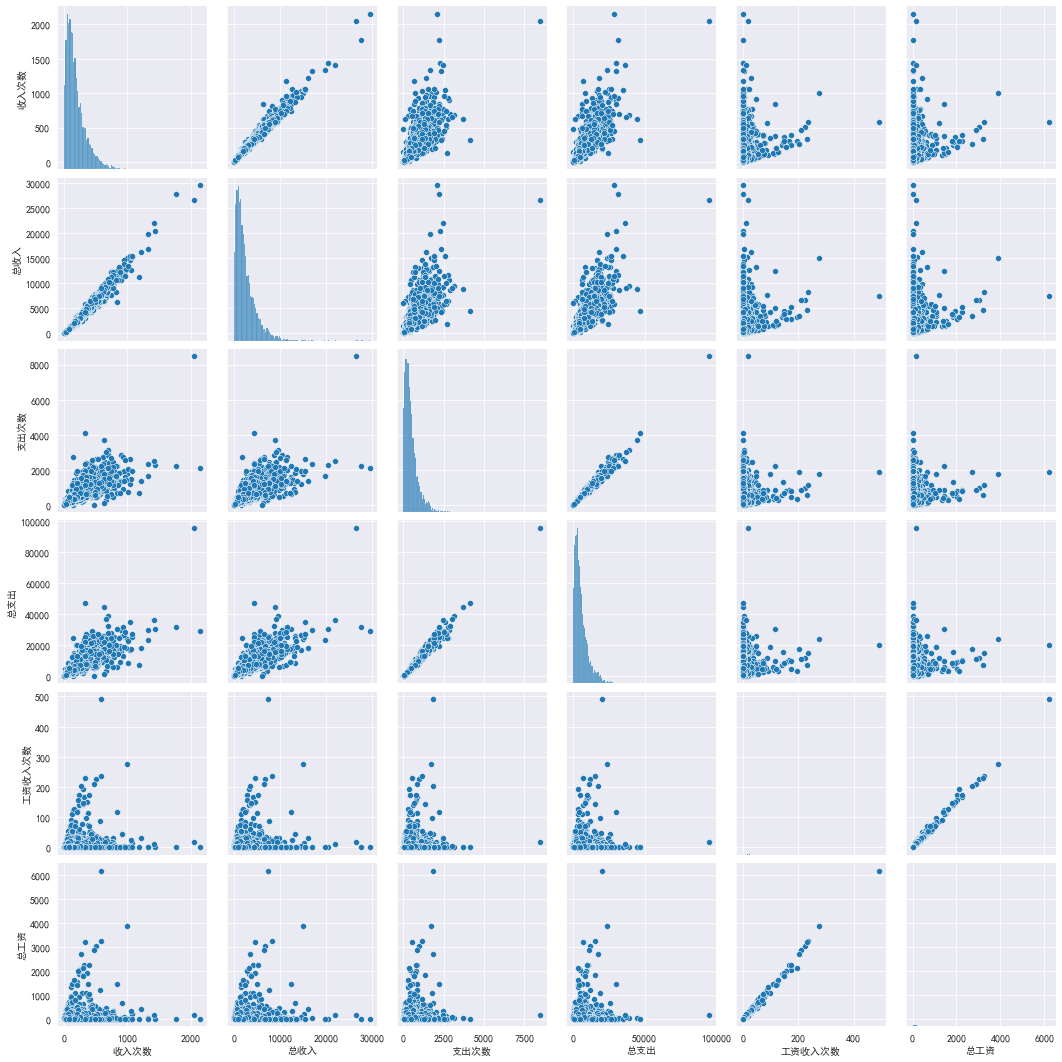

In [51]:
sns.pairplot(train_table.iloc[:, 6:12])

收入次数和总收入基本线性关系，但收入主要靠工资，所以这里使用后面的工资代表收入程度   
支出次数和总支出基本线性关系， 可以通过计算平均每次的支出代表支出程度   

工资收入次数和工资多少虽说呈线性，但是这是因为有接近一半的人没有工资，需要重新筛选画图才能得出结论

<AxesSubplot:>

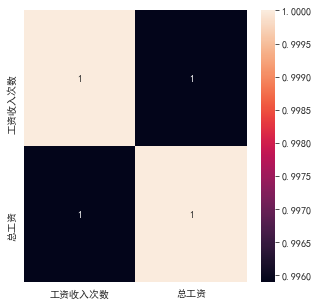

In [52]:
plt.figure(figsize=(5, 5))
sns.heatmap(train_table[train_table["总工资"] !=
                        0].iloc[:, 10:12].corr(), annot=True)

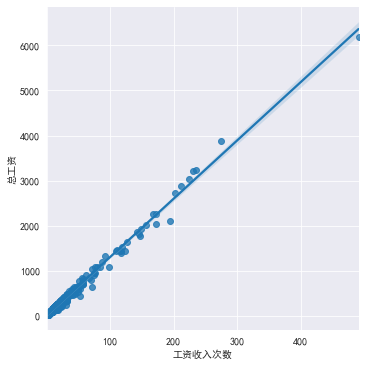

In [53]:
sns.lmplot(data=train_table[train_table["总工资"] !=
                            0].iloc[:, 10:12], x="工资收入次数", y="总工资")

的确呈线程，工资收入次数和工资多少呈线性，可以取平均用来代表工资程度

## 账单分析

<AxesSubplot:>

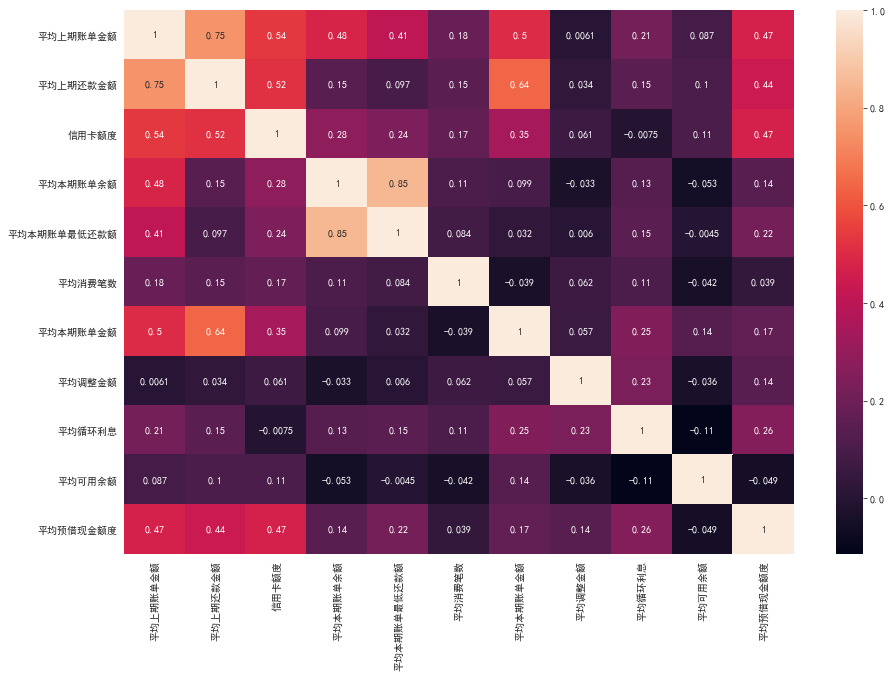

In [54]:
plt.figure(figsize=(15, 10))
sns.heatmap(train_table.iloc[:, 13:24].corr(), annot=True)

**本期应还金额 = 上期账单金额-上期还款金额 + 本期账单金额 - 本期调整金额 + 循环利息**

上期还款金额 <上期账单的最低还款额（一般是账单金额*10%）或者不还，就视为逾期，而且本期的还款要加上循环利息和上期未还款的那部分。

上期最低还款额<上期还款金额<上期账单金额，不视为逾期，但本期的还款要加上循环利息

上期还款金额 >上期账单金额，也就是说用户还多了，那么本期的还款会减去一个调整金额（多还的那部分），循环利息不计。  (举个例子，在当期你使用信用卡在线支付了1000元飞机票，然而由于原因你退掉了这张飞机票，那么银行会将之前扣掉的1000元在给你打回账户中。这个1000元就是本期调整金额。)

也就是说上期还款金额和本次还款金额相关,主要在于上期还款金额与上期最低还款额，上期账单金额的大小关系  
但是这里没有上期最低还款恩度，所以只能计算上期还款金额-上期账单大小

预借现金额度，是指持卡人使用信用卡通过ATM等自助终端提取现金的最高额度，取现额度包含于信用额度之内，一般是信用额度的50%左右，所以可以不用这个特征，选择信用额度即可

## 数据处理

- 目标特征：
    - 用户属性
        - 性别
        - 教育程度
        - 婚姻状况
        - 职业
        - 户口类型
    - 用户浏览情况：
        - 浏览次数
    - 经济情况
        - 收入程度
        - 支出程度
    - 账单记录
        - 上期还款差额（上期还款金额-上期账单金额）
        - 本期账单金额
        - 本期最低还款额
        - 消费笔数
        - 信用卡额度
        - ~上期还款达标差（上期还款金额-上期最低还款额）(无法计算)~

In [55]:
train_table["收入程度"] = train_table.apply(
    lambda x: x.总工资/x.工资收入次数 if x.工资收入次数 != 0 else 0, axis=1)

In [56]:
train_table["支出程度"] = train_table.apply(
    lambda x: x.总支出/x.支出次数 if x.支出次数 != 0 else 0, axis=1)

In [57]:
train_table["上期还款差额"] = train_table.apply(
    lambda x: x.平均上期还款金额-x.平均上期账单金额, axis=1)

In [58]:
train_table2 = train_table.drop(["收入次数", "总收入", "支出次数", "总支出", "工资收入次数", "总工资", "平均上期账单金额",
                                 "平均上期还款金额", "平均本期账单余额",  "平均调整金额", "平均循环利息", "平均可用余额", "平均预借现金额度"], axis=1)

In [59]:
train_table2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5735 entries, 0 to 5734
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   用户id         5735 non-null   int64  
 1   用户性别         5735 non-null   int64  
 2   用户职业         5735 non-null   int64  
 3   用户教育程度       5735 non-null   int64  
 4   用户婚姻状态       5735 non-null   int64  
 5   用户户口类型       5735 non-null   int64  
 6   浏览次数         5735 non-null   int64  
 7   信用卡额度        5735 non-null   float64
 8   平均本期账单最低还款额  5735 non-null   float64
 9   平均消费笔数       5735 non-null   float64
 10  平均本期账单金额     5735 non-null   float64
 11  是否逾期         5735 non-null   int64  
 12  收入程度         5735 non-null   float64
 13  支出程度         5735 non-null   float64
 14  上期还款差额       5735 non-null   float64
dtypes: float64(7), int64(8)
memory usage: 716.9 KB


# 特征选择

## 使用嵌入法挑选

In [60]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as RFC

In [61]:
s = SelectFromModel(RFC()).fit(train_table.drop(
    ["用户id", "是否逾期"], axis=1), train_table["是否逾期"])

In [62]:
s.estimator_.feature_importances_

array([0.02208979, 0.01051374, 0.013773  , 0.01721807, 0.01878753,
       0.04785051, 0.05117001, 0.04933981, 0.05185985, 0.01304462,
       0.01913989, 0.05703171, 0.05142498, 0.05193783, 0.05091266,
       0.05887154, 0.0568992 , 0.04741253, 0.05057222, 0.01835842,
       0.02422822, 0.01745688, 0.04310027, 0.01879194, 0.07135357,
       0.06686122])

In [63]:
s.threshold_

0.038461538461538464

In [64]:
s.get_support()

array([False, False, False, False, False,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False,  True, False,  True,  True])

In [65]:
s1 = SelectFromModel(RFC()).fit(train_table2.drop(
    ["是否逾期", "用户id"], axis=1), train_table2["是否逾期"])

In [66]:
s1.estimator_.feature_importances_

array([0.02882919, 0.0202585 , 0.02744414, 0.03012934, 0.0372017 ,
       0.11358153, 0.10783144, 0.1202756 , 0.09468498, 0.10406112,
       0.04948566, 0.13981084, 0.12640597])

In [67]:
s1.threshold_

0.07692307692307693

In [68]:
pd.DataFrame(list(zip(list(train_table2.drop(["是否逾期", "用户id"], axis=1).columns), s1.get_support(
), s1.estimator_.feature_importances_))).sort_values(by=2)

,0,1,2
1,用户职业,False,0.020258
2,用户教育程度,False,0.027444
0,用户性别,False,0.028829
3,用户婚姻状态,False,0.030129
4,用户户口类型,False,0.037202
10,收入程度,False,0.049486
8,平均消费笔数,True,0.094685
9,平均本期账单金额,True,0.104061
6,信用卡额度,True,0.107831
5,浏览次数,True,0.113582


可以发现特征筛选后的确有效果

## 使用f_classif 过滤

In [69]:
from sklearn.feature_selection import f_classif, SelectKBest

In [70]:
select_k_bset = SelectKBest(f_classif, k=5)

In [71]:
a = select_k_bset.fit(train_table2.drop(
    ["是否逾期", "用户id"], axis=1), train_table2["是否逾期"])

In [72]:
a.get_support()

array([ True, False,  True, False, False, False, False,  True, False,
       False,  True,  True, False])

In [73]:
list(zip(train_table2.drop(["是否逾期", "用户id"], axis=1).columns, a.get_support()))

[('用户性别', True),
 ('用户职业', False),
 ('用户教育程度', True),
 ('用户婚姻状态', False),
 ('用户户口类型', False),
 ('浏览次数', False),
 ('信用卡额度', False),
 ('平均本期账单最低还款额', True),
 ('平均消费笔数', False),
 ('平均本期账单金额', False),
 ('收入程度', True),
 ('支出程度', True),
 ('上期还款差额', False)]

## 得到结果

综合两者，使用以下特征：

- 用户性别
- 用户教育程度
- 收入程度
- 支出程度
- 浏览次数
- 上期还款差额
- 信用卡额度
- 平均本期账单最低还款额
- 平均消费笔数
- 平均本期账单金额



In [74]:
train_table2 = train_table2.loc[:, ["用户性别", "用户教育程度", "收入程度", "支出程度",
                                    "浏览次数", "上期还款差额", "信用卡额度", "平均本期账单最低还款额", "平均消费笔数", "平均本期账单金额", "是否逾期"]]

In [75]:
train_table2.head()

,用户性别,用户教育程度,收入程度,支出程度,浏览次数,上期还款差额,信用卡额度,平均本期账单最低还款额,平均消费笔数,平均本期账单金额,是否逾期
0,1,4,0.000000,11.192152,1710,2.730547,19.971271,17.220095,10.750000,18.825107,0
1,1,4,0.000000,12.457337,420,-3.524092,19.973385,17.866453,1.444444,19.007284,0
2,2,2,0.000000,11.430923,702,0.073337,18.307126,10.292788,1.791667,17.199134,0
3,1,4,14.473609,10.781947,783,19.825318,19.740221,15.902257,0.000000,12.969975,0
4,1,4,0.000000,11.034576,671,-12.607495,17.309158,18.206423,2.251572,15.892834,0


In [76]:
train_table2.to_csv("./product/filter_feature.csv",index=False)

# 不同处理程度后跑分比较

比较不同处理程度的数据集哪一个更有效

In [77]:
feature_label = pd.read_csv("./product/filter_feature.csv")

In [78]:
# 经过清洗并且提取完特征后的数据集
feature_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5735 entries, 0 to 5734
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   用户性别         5735 non-null   int64  
 1   用户教育程度       5735 non-null   int64  
 2   收入程度         5735 non-null   float64
 3   支出程度         5735 non-null   float64
 4   浏览次数         5735 non-null   int64  
 5   上期还款差额       5735 non-null   float64
 6   信用卡额度        5735 non-null   float64
 7   平均本期账单最低还款额  5735 non-null   float64
 8   平均消费笔数       5735 non-null   float64
 9   平均本期账单金额     5735 non-null   float64
 10  是否逾期         5735 non-null   int64  
dtypes: float64(7), int64(4)
memory usage: 493.0 KB


In [79]:
feature_label_rough = pd.read_csv("./product/filter_data.csv")

In [80]:
# 经过清洗，并且保留主要特征后的数据集。
feature_label_rough.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5735 entries, 0 to 5734
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   用户id         5735 non-null   int64  
 1   用户性别         5735 non-null   int64  
 2   用户职业         5735 non-null   int64  
 3   用户教育程度       5735 non-null   int64  
 4   用户婚姻状态       5735 non-null   int64  
 5   用户户口类型       5735 non-null   int64  
 6   收入次数         5735 non-null   float64
 7   总收入          5735 non-null   float64
 8   支出次数         5735 non-null   float64
 9   总支出          5735 non-null   float64
 10  工资收入次数       5735 non-null   float64
 11  总工资          5735 non-null   float64
 12  浏览次数         5735 non-null   int64  
 13  平均上期账单金额     5735 non-null   float64
 14  平均上期还款金额     5735 non-null   float64
 15  信用卡额度        5735 non-null   float64
 16  平均本期账单余额     5735 non-null   float64
 17  平均本期账单最低还款额  5735 non-null   float64
 18  平均消费笔数       5735 non-null   float64
 19  平均本期账单

In [81]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [82]:
x_train,x_test,y_train,y_test = train_test_split(feature_label.iloc[:,0:-1],feature_label["是否逾期"],test_size=0.25)

In [83]:
x_train2,x_test2,y_train2,y_test2 = train_test_split(feature_label_rough.drop("是否逾期",axis=1),feature_label["是否逾期"],test_size=0.25)

In [84]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4301 entries, 1795 to 4909
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   用户性别         4301 non-null   int64  
 1   用户教育程度       4301 non-null   int64  
 2   收入程度         4301 non-null   float64
 3   支出程度         4301 non-null   float64
 4   浏览次数         4301 non-null   int64  
 5   上期还款差额       4301 non-null   float64
 6   信用卡额度        4301 non-null   float64
 7   平均本期账单最低还款额  4301 non-null   float64
 8   平均消费笔数       4301 non-null   float64
 9   平均本期账单金额     4301 non-null   float64
dtypes: float64(7), int64(3)
memory usage: 369.6 KB


In [85]:
x_train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4301 entries, 2873 to 5514
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   用户id         4301 non-null   int64  
 1   用户性别         4301 non-null   int64  
 2   用户职业         4301 non-null   int64  
 3   用户教育程度       4301 non-null   int64  
 4   用户婚姻状态       4301 non-null   int64  
 5   用户户口类型       4301 non-null   int64  
 6   收入次数         4301 non-null   float64
 7   总收入          4301 non-null   float64
 8   支出次数         4301 non-null   float64
 9   总支出          4301 non-null   float64
 10  工资收入次数       4301 non-null   float64
 11  总工资          4301 non-null   float64
 12  浏览次数         4301 non-null   int64  
 13  平均上期账单金额     4301 non-null   float64
 14  平均上期还款金额     4301 non-null   float64
 15  信用卡额度        4301 non-null   float64
 16  平均本期账单余额     4301 non-null   float64
 17  平均本期账单最低还款额  4301 non-null   float64
 18  平均消费笔数       4301 non-null   float64
 19  平均本

## 筛选过特征

In [86]:
LogisticRegression().fit(x_train,y_train).score(x_test,y_test)

D:\learn\anaconda3\envs\learn\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8507670850767085

In [87]:
DecisionTreeClassifier().fit(x_train,y_train).score(x_test,y_test)

0.7426778242677824

In [88]:
RandomForestClassifier().fit(x_train,y_train).score(x_test,y_test)

0.8479776847977685

In [89]:
SVC().fit(x_train,y_train).score(x_test,y_test)

0.8507670850767085

In [90]:
XGBClassifier().fit(x_train,y_train).score(x_test,y_test)

0.8479776847977685

## 仅清洗过，未筛选特征

In [91]:
LogisticRegression().fit(x_train2,y_train2).score(x_test2,y_test2)

D:\learn\anaconda3\envs\learn\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8472803347280334

In [92]:
DecisionTreeClassifier().fit(x_train2,y_train2).score(x_test2,y_test2)

0.7266387726638772

In [93]:
RandomForestClassifier().fit(x_train2,y_train2).score(x_test2,y_test2)

0.8500697350069735

In [94]:
SVC().fit(x_train2,y_train2).score(x_test2,y_test2)

0.8479776847977685

In [95]:
XGBClassifier().fit(x_train2,y_train2).score(x_test2,y_test2)

0.8403068340306834

## 结论

可以发现，列数降低为了原来的三分之一，而正确率变化都在百分之一之内。特征处理十分成功